In [43]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load data
data = pd.read_csv('../data/processed/summary_of_weather_processed.csv', low_memory=False)
data['Date'] = pd.to_datetime(data['Date'])


Train-test split


In [44]:
# Split: train on earlier years, test on later years
# Use year cutoff to avoid data leakage
split_year = 44  # Train on 1940-1944, test on 1945
train_data = data[data['YR'] <= split_year].copy()
test_data = data[data['YR'] > split_year].copy()
print(f"   Train period: {train_data['Date'].min().date()} to {train_data['Date'].max().date()}")
print(f"   Test period:  {test_data['Date'].min().date()} to {test_data['Date'].max().date()}")
print(f"   Train size: {len(train_data)} | Test size: {len(test_data)}")

   Train period: 1940-01-01 to 1944-12-31
   Test period:  1945-01-01 to 1945-12-31
   Train size: 80830 | Test size: 38210


Feature selection


In [45]:
feature_cols = ['MinTemp', 'Precip', 'month', 'dayofyear', 'is_winter', 'is_summer',
                'station_mean_maxtemp', 'station_count']

X_train = train_data[feature_cols].copy()
y_train = train_data['MaxTemp'].copy()

X_test = test_data[feature_cols].copy()
y_test = test_data['MaxTemp'].copy()

print(f"   Features: {feature_cols}")
print(f"   Train: {X_train.shape} | Test: {X_test.shape}")

   Features: ['MinTemp', 'Precip', 'month', 'dayofyear', 'is_winter', 'is_summer', 'station_mean_maxtemp', 'station_count']
   Train: (80830, 8) | Test: (38210, 8)


Standardization

In [46]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Model training & evaluation

In [47]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("\n" + "=" * 60)
print("RESULTS (Time-based split, station encoding, no leakage)")
print("=" * 60)
print(f"\nTrain Set Metrics:")
print(f"  MAE:  {train_mae:.4f} °C")
print(f"  RMSE: {train_rmse:.4f} °C")
print(f"  r2 score:   {train_r2:.6f}")

print(f"\nTest Set Metrics (Future data - TRUE PERFORMANCE):")
print(f"  MAE:  {test_mae:.4f} °C")
print(f"  RMSE: {test_rmse:.4f} °C")
print(f"  r2 score:   {test_r2:.6f}")

print(f"\nOverfitting Analysis:")
print(f"  r2 score (train - test): {train_r2 - test_r2:.6f}")
if abs(train_r2 - test_r2) < 0.05:
    print(f"  Minimal overfitting (Δ < 0.05)")
else:
    print(f"  Significant overfitting detected (Δ > 0.05)")


RESULTS (Time-based split, station encoding, no leakage)

Train Set Metrics:
  MAE:  2.6418 °C
  RMSE: 3.6294 °C
  r2 score:   0.833433

Test Set Metrics (Future data - TRUE PERFORMANCE):
  MAE:  2.7958 °C
  RMSE: 3.7184 °C
  r2 score:   0.800898

Overfitting Analysis:
  r2 score (train - test): 0.032535
  Minimal overfitting (Δ < 0.05)


Feature importance

In [48]:
print(f"Feature Importance (coefficients):")
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

for idx, row in feature_importance.iterrows():
    print(f"   {row['Feature']:30s}: {row['Abs_Coefficient']:7.4f}")

Feature Importance (coefficients):
   MinTemp                       :  5.8791
   station_mean_maxtemp          :  2.6927
   Precip                        :  0.6288
   station_count                 :  0.5503
   dayofyear                     :  0.4888
   is_winter                     :  0.3966
   month                         :  0.3155
   is_summer                     :  0.0560


Error analysis by month

In [49]:
print(f"Error Analysis by Time Period...")

test_data_with_pred = test_data.copy()
test_data_with_pred['pred'] = y_test_pred
test_data_with_pred['error'] = np.abs(y_test - y_test_pred)

yearly_error = test_data_with_pred.groupby(test_data_with_pred['Date'].dt.month).agg({
    'error': ['mean', 'std', 'count']
}).round(4)
yearly_error.columns = ['MAE', 'Std_Error', 'Count']

print(yearly_error)

Error Analysis by Time Period...
         MAE  Std_Error  Count
Date                          
1     2.8741     2.8884   3574
2     2.6011     1.9769   3176
3     2.7252     2.1280   3707
4     2.7864     2.2963   3631
5     3.0133     2.5039   3659
6     3.1648     2.6154   3365
7     3.1668     2.7762   3271
8     2.9184     2.5927   3141
9     2.6805     2.7283   2821
10    2.5436     2.4769   2711
11    2.4306     2.0279   2582
12    2.3878     1.8447   2572


Visualization


✓ Saved plot to ../results/01_same_day_maxtemp_fixed.png


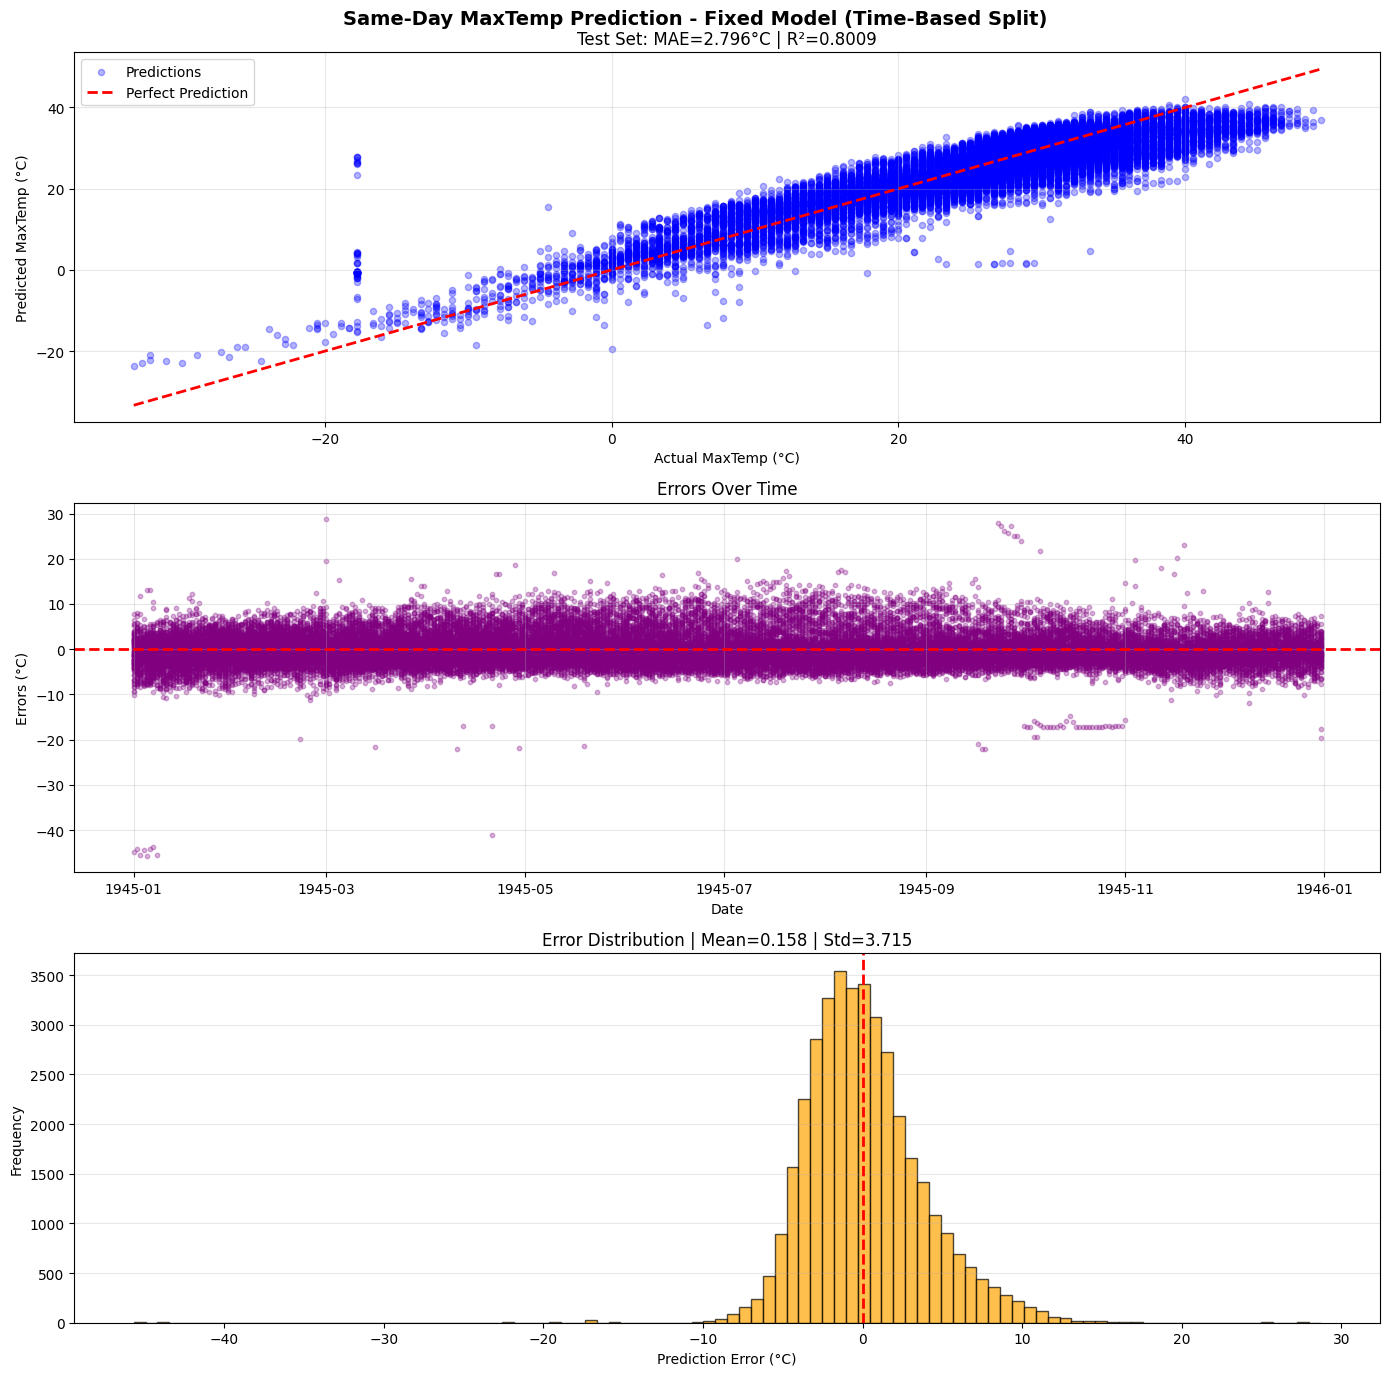

In [50]:
fig, axes = plt.subplots(3, figsize=(14, 14))
fig.suptitle('Same-Day MaxTemp Prediction - Fixed Model (Time-Based Split)', fontsize=14, fontweight='bold')

# Plot 1: Actual vs Predicted
axes[0].scatter(y_test, y_test_pred, alpha=0.3, s=20, color='blue', label='Predictions')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual MaxTemp (°C)')
axes[0].set_ylabel('Predicted MaxTemp (°C)')
axes[0].set_title(f'Test Set: MAE={test_mae:.3f}°C | R²={test_r2:.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Errors over time
axes[1].scatter(test_data['Date'], y_test - y_test_pred, alpha=0.3, s=10, color='purple')
axes[1].axhline(0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Errors (°C)')
axes[1].set_title('Errors Over Time')
axes[1].grid(True, alpha=0.3)

# Plot 3: Distribution of errors
axes[2].hist(y_test - y_test_pred, bins=100, color='orange', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Prediction Error (°C)')
axes[2].set_ylabel('Frequency')
axes[2].set_title(f'Error Distribution | Mean={np.mean(y_test - y_test_pred):.3f} | Std={np.std(y_test - y_test_pred):.3f}')
axes[2].axvline(0, color='red', linestyle='--', lw=2)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../results/01_same_day_maxtemp_fixed.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved plot to ../results/01_same_day_maxtemp_fixed.png")
plt.show()